### 导入数据

In [2]:
import skimage.io as io
import numpy as np

# 训练样本
file='./data/train/*.jpg'
coll = io.ImageCollection(file)
X_train = np.asarray(coll)                                   # 500 个训练样本，250 个猫图片，250 个非猫图片
y_train = np.hstack((np.ones(250),np.zeros(250)))            # 输出标签 

# 测试样本
file='./data/test/*.jpg'
coll = io.ImageCollection(file)
X_test = np.asarray(coll)                                   # 200 个训练样本，100 个猫图片，100 个非猫图片
y_test = np.hstack((np.ones(100),np.zeros(100)))            # 输出标签 

m_train = X_train.shape[0]
m_test = X_test.shape[0]
w, h, d = X_train.shape[1], X_train.shape[2], X_train.shape[3]

print('训练样本数量：%d' % m_train)
print('测试样本数量：%d' % m_test)
print('每张图片的维度：(%d, %d, %d)' % (w, h, d))

训练样本数量：500
测试样本数量：200
每张图片的维度：(64, 64, 3)


从训练样本中随机选择 10 张图片显示，y = 1 表示是猫类图片；y = 0 表示非猫类图片。

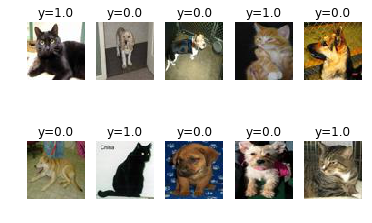

In [3]:
import matplotlib.pyplot as plt

idx = [np.random.choice(m_train) for _ in range(10)]  # 随机选择 10 张图片
label = y_train[idx]
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, 5*i+j+1)
        plt.imshow(X_train[idx[5*i+j]])
        plt.title("y="+str(label[5*i+j]))
        plt.axis('off')
plt.show()

### 预处理

In [4]:
# 图片矩阵转化为一维向量
X_train = X_train.reshape(m_train, -1).T
X_test = X_test.reshape(m_test, -1).T

print('训练样本维度：' + str(X_train.shape))
print('测试样本维度：' + str(X_test.shape))

# 图片像素归一化到 [0,1] 之间
X_train = X_train / 255
X_test = X_test / 255

训练样本维度：(12288, 500)
测试样本维度：(12288, 200)


### 初始化参数 W 和 b

In [5]:
def initialize_parameters(layer_dims):
    
    parameters = {}          # 存储参数 W 和 b 的字典
    L = len(layer_dims)      # 神经网络的层数，包含输入层

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) * 0.1
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
       
    return parameters

### 正向传播单层神经元

In [6]:
# sigmoid 函数
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    
    return A

# relu 函数
def relu(Z):
    
    A = np.maximum(0,Z)
    
    return A

# 单个神经元运算单元
def linear_activation_forward(A_prev, W, b, activation):
    
    Z = np.dot(W, A_prev) + b        # 线性输出
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    
    cache = (A_prev, W, b, Z)
    
    return A, cache

### 正向传播 L 层神经元

In [7]:
def model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # 神经网络层数 L
    
    # L-1 层使用 ReLU
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    # L 层使用 Sigmoid
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
            
    return AL, caches

### 损失函数

In [8]:
def compute_cost(AL, Y):
    
    m = AL.shape[1]

    cost = -1/m*np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL))
    
    cost = np.squeeze(cost)      # 压缩维度，保证损失函数值维度正确，例如 [[10]] -> 10
    
    return cost

### 反向传播单层神经元

首先需要定义 ReLU 的求导函数

In [9]:
def relu_backward(dA, Z):
    
    dZ = np.array(dA, copy=True)  
    dZ[Z <= 0] = 0
    
    return dZ

然后需要定义 Sigmoid 的求导函数。

In [10]:
def sigmoid_backward(dA, Z):
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

接下来是定义单层神经元反向传播函数。

In [11]:
def linear_activation_backward(dA, cache, activation):
    
    A_prev, W, b, Z = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, Z)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, Z)
    
    m = dA.shape[1]
    dW = 1/m*np.dot(dZ,A_prev.T)
    db = 1/m*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

### 反向传播 L 层神经元

In [12]:
def model_backward(AL, Y, caches):

    grads = {}
    L = len(caches)         # 神经网络层数，包括输入层
    m = AL.shape[1]         # 样本个数
    Y = Y.reshape(AL.shape) # 保证 Y 与 AL 维度一致
    
    # AL 值
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # 第 L 层，激活函数是 Sigmoid
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    # 前 L-1 层，激活函数是 ReLU
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### 更新网络参数 W 和 b

In [13]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2           # 神经网络层数，包括输入层

    for l in range(L):
        parameters["W" + str(l+1)] -=  learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -=  learning_rate*grads["db" + str(l+1)]

    return parameters

### 整个神经网络模型

In [14]:
def nn_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         
    
    # 参数初始化
    parameters = initialize_parameters(layers_dims)
    
    # 迭代训练
    for i in range(0, num_iterations):

        # 正向传播
        AL, caches = model_forward(X, parameters)
        
        # 计算损失函数
        cost = compute_cost(AL, Y)
    
        # 反向传播
        grads = model_backward(AL, Y, caches)
 
        # 更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # 每迭代 100 次，打印 cost
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # 绘制 cost 趋势图
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundred)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### 模型预测

In [15]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # 正向传播
    AL, caches = model_forward(X, parameters)
    predictions = AL > 0.5
    
    accuracy = np.mean(predictions == y)
 
    print("Accuracy: %f" % accuracy)
        
    return predictions

### 训练模型

先设计一个简单的 2 层神经网络。

Cost after iteration 0: 0.934291
Cost after iteration 100: 0.654145
Cost after iteration 200: 0.598071
Cost after iteration 300: 0.491806
Cost after iteration 400: 0.952094
Cost after iteration 500: 0.426875
Cost after iteration 600: 0.838886
Cost after iteration 700: 0.832011
Cost after iteration 800: 0.218174
Cost after iteration 900: 0.190239
Cost after iteration 1000: 0.424622
Cost after iteration 1100: 0.181183
Cost after iteration 1200: 0.243990
Cost after iteration 1300: 0.125354
Cost after iteration 1400: 0.179002


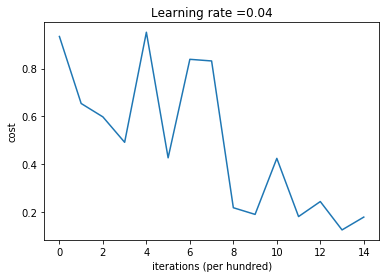

In [116]:
layers_dims = [12288, 10, 1] #  2-layer model
parameters = nn_model(X_train, y_train, layers_dims, learning_rate = 0.04, num_iterations = 1500, print_cost = True)

In [117]:
pred_train = predict(X_train, y_train, parameters)

Accuracy: 0.984000


In [118]:
pred_test = predict(X_test, y_test, parameters)

Accuracy: 0.570000


再设计一个较复杂的 5 层神经网络。

Cost after iteration 0: 0.693274
Cost after iteration 100: 0.693000
Cost after iteration 200: 0.692647
Cost after iteration 300: 0.692013
Cost after iteration 400: 0.690574
Cost after iteration 500: 0.686974
Cost after iteration 600: 0.675996
Cost after iteration 700: 0.646076
Cost after iteration 800: 0.626832
Cost after iteration 900: 0.561664
Cost after iteration 1000: 0.521846
Cost after iteration 1100: 0.460633
Cost after iteration 1200: 0.337490
Cost after iteration 1300: 0.232980
Cost after iteration 1400: 0.051204


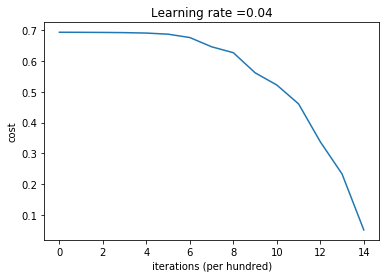

In [110]:
layers_dims = [12288, 100, 50, 10, 4, 1] #  4-layer model
parameters = nn_model(X_train, y_train, layers_dims, learning_rate = 0.04, num_iterations = 1500, print_cost = True)

In [111]:
pred_train = predict(X_train, y_train, parameters)

Accuracy: 0.998000


In [112]:
pred_test = predict(X_test, y_test, parameters)

Accuracy: 0.625000
